In [28]:
# PART 1: Spark aggregation to state-year (weighted rates/means)
from pyspark.sql import SparkSession, functions as F
from pathlib import Path

BASE = "/Users/compiling/435Project/Project"
COMPLETE_DIR = Path(BASE) / "complete"

spark = SparkSession.builder.appName("MicroAggregateForSklearn").getOrCreate()

micro = spark.read.parquet(str(COMPLETE_DIR / "pums_*.parquet"))
print("Total micro rows (all years):", micro.count())

weight_col = 'PWGTP'
group_cols = ['STATE_NAME', 'YEAR']
wt_sum = F.sum(weight_col)

features = [
    wt_sum.alias('state_year_population'),
    F.first('TOTAL_HEALTH_SPENDING').alias('TOTAL_HEALTH_SPENDING'),

    # Demographics
    (F.sum(F.when(F.col('AGEP') >= 65, F.col(weight_col)).otherwise(0)) / wt_sum).alias('AGEP_65plus_share'),
    (F.sum(F.when(F.col('AGEP') <= 17, F.col(weight_col)).otherwise(0)) / wt_sum).alias('AGEP_0_17_share'),
    (F.sum(F.when(F.col('SEX') == 2, F.col(weight_col)).otherwise(0)) / wt_sum).alias('SEX_female_share'),
    (F.sum(F.when(F.col('MAR').isin(1, 2, 3), F.col(weight_col)).otherwise(0)) / wt_sum).alias('MAR_ever_married_share'),

    # Health insurance coverage
    (F.sum(F.when(F.col('HICOV') == 2, F.col(weight_col)).otherwise(0)) / wt_sum).alias('HICOV_uninsured_share'),
    (F.sum(F.when(F.col('HINS1') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('HINS1_employer_share'),
    (F.sum(F.when(F.col('HINS2') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('HINS2_direct_share'),
    (F.sum(F.when(F.col('HINS3') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('HINS3_medicare_share'),
    (F.sum(F.when(F.col('HINS4') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('HINS4_medicaid_share'),
    (F.sum(F.when(F.col('HINS5') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('HINS5_tricare_share'),
    (F.sum(F.when(F.col('HINS6') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('HINS6_va_share'),

    # Economic & income
    (F.sum(F.when(F.col('POVPIP') < 138, F.col(weight_col)).otherwise(0)) / wt_sum).alias('POVPIP_lt138_share'),
    (F.sum(F.col('PINCP') * F.col(weight_col)) / wt_sum).alias('PINCP_mean'),
    (F.sum(F.col('WAGP') * F.col(weight_col)) / wt_sum).alias('WAGP_mean'),
    (F.sum(F.col('SEMP') * F.col(weight_col)) / F.sum(F.when(F.col('SEMP') > 0, F.col(weight_col)).otherwise(None))).alias('SEMP_mean_if_positive'),
    (F.sum(F.col('SSP') * F.col(weight_col)) / wt_sum).alias('SSP_per_capita'),
    (F.sum(F.when(F.col('RETP') > 0, F.col(weight_col)).otherwise(0)) / wt_sum).alias('RETP_positive_share'),

    # Employment & labor
    (F.sum(F.when(F.col('ESR').isin(3, 6), F.col(weight_col)).otherwise(0)) / wt_sum).alias('ESR_unemp_or_nilf_share'),
    (F.sum(F.when(F.col('ESR').isin(1, 2, 3, 4, 5), F.col(weight_col)).otherwise(0)) / wt_sum).alias('ESR_in_labor_force_share'),

    # Education & social
    (F.sum(F.when(F.col('SCHL') >= 21, F.col(weight_col)).otherwise(0)) / wt_sum).alias('SCHL_bach_plus_share'),
    (F.sum(F.when(F.col('DOUT') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('DOUT_diff_share'),
    (F.sum(F.when(F.col('DPHY') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('DPHY_diff_share'),
    (F.sum(F.when(F.col('DIS') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('DIS_any_share'),
    (
        1000.0
        * F.sum(
            F.when(
                (F.col('SEX') == 2) & (F.col('AGEP').between(15, 50)) & (F.col('FER') == 1),
                F.col(weight_col),
            ).otherwise(0)
        )
        / F.sum(F.when((F.col('SEX') == 2) & (F.col('AGEP').between(15, 50)), F.col(weight_col)).otherwise(None))
    ).alias('FER_births_per_1000_women_15_50'),

    # Access & lifestyle
    (F.sum(F.when(F.col('BROADBND') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('BROADBND_yes_share'),
    (F.sum(F.col('VEH') * F.col(weight_col)) / wt_sum).alias('VEH_mean_per_person'),
    (F.sum(F.when(F.col('MIL').isin(2, 3), F.col(weight_col)).otherwise(0)) / wt_sum).alias('MIL_veteran_share'),
    (F.sum(F.when(F.col('MIL') == 1, F.col(weight_col)).otherwise(0)) / wt_sum).alias('MIL_active_duty_share'),
]

print("Aggregating microdata to state-year panel ...")
df_state_year = (
    micro
    .groupBy(*group_cols)
    .agg(*features)
    .toPandas()
)
print('Final panel shape:', df_state_year.shape)
df_state_year.head()


ConnectionRefusedError: [Errno 61] Connection refused

In [12]:
# PART 2: Pooled RF model (per-capita target, shuffled split)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

# Verify target uniqueness per state-year
leakage_counts = df_state_year.groupby(['STATE_NAME', 'YEAR'])['TOTAL_HEALTH_SPENDING'].nunique()
print('Target nunique per state-year:')
print(leakage_counts.value_counts().sort_index())
print('Summary:')
print(leakage_counts.describe())

target = 'TOTAL_HEALTH_SPENDING'  # per-capita dollars
categorical_cols = []  # drop STATE_NAME for pooled drivers
drop_from_X = {
    target, 'STATE_NAME', 'ST', 'state_year_population',
    'SSP_per_capita', 'RETP_positive_share',
    'DOUT_diff_share', 'DPHY_diff_share',
}
numeric_cols = [c for c in df_state_year.columns if c not in drop_from_X]

X = df_state_year[categorical_cols + numeric_cols]
y = df_state_year[target]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)
print(f'Training on {len(X_train)} samples, Testing on {len(X_test)} samples')

preprocess = ColumnTransformer([
    ('num', 'passthrough', numeric_cols),
])

rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=15,
    n_jobs=-1,
    random_state=42,
)

pipe = Pipeline([('pre', preprocess), ('rf', rf)])
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Test R^2 : {r2:,.3f}')
print(f'Test MAE : {mae:,.2f}')
print(f'Test RMSE: {rmse:,.2f}')


Target nunique per state-year:
TOTAL_HEALTH_SPENDING
1    255
Name: count, dtype: int64
Summary:
count    255.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: TOTAL_HEALTH_SPENDING, dtype: float64
Training on 204 samples, Testing on 51 samples
Test R^2 : 0.733
Test MAE : 612.74
Test RMSE: 755.42


In [13]:
# PART 2b: Random Forest feature importances

if hasattr(pipe, 'named_steps') and 'rf' in pipe.named_steps:
    import numpy as np
    import pandas as pd

    rf_model = pipe.named_steps['rf']
    importances = rf_model.feature_importances_
    fi = pd.DataFrame({
        'feature': numeric_cols,
        'importance': importances,
    }).sort_values('importance', ascending=False)
    print('Top 15 feature importances:')
    print(fi.head(15).to_string(index=False))
else:
    print('RandomForestRegressor not found in pipeline; skipping importances')


Top 15 feature importances:
                 feature  importance
   HICOV_uninsured_share    0.189375
              PINCP_mean    0.120270
     VEH_mean_per_person    0.119567
                    YEAR    0.060293
      HINS2_direct_share    0.050506
   SEMP_mean_if_positive    0.049059
          HINS6_va_share    0.041574
        SEX_female_share    0.034009
         AGEP_0_17_share    0.033838
       AGEP_65plus_share    0.032453
    HINS3_medicare_share    0.029749
    HINS4_medicaid_share    0.028890
 ESR_unemp_or_nilf_share    0.024542
ESR_in_labor_force_share    0.021010
   MIL_active_duty_share    0.019115


In [14]:
# PART 2c: Top 5 feature importances per year (separate RF per year)
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

years = sorted(df_state_year['YEAR'].unique())
print('Per-year RF importances (top 5):')

for yr in years:
    df_y = df_state_year[df_state_year['YEAR'] == yr].copy()
    if df_y.shape[0] < 10:
        print(f'Year {yr}: skipped (too few rows: {df_y.shape[0]})')
        continue

    X_y = df_y[numeric_cols]
    y_y = df_y[target]

    rf_y = RandomForestRegressor(
        n_estimators=300,
        max_depth=10,
        n_jobs=-1,
        random_state=42,
    )
    rf_y.fit(X_y, y_y)

    fi = pd.DataFrame({
        'feature': numeric_cols,
        'importance': rf_y.feature_importances_,
    }).sort_values('importance', ascending=False).head(5)
    print(f'Year {yr} (rows={len(df_y)}):')
    print(fi.to_string(index=False))
 


Per-year RF importances (top 5):
Year 2019 (rows=51):
                 feature  importance
   HICOV_uninsured_share    0.210674
ESR_in_labor_force_share    0.112111
     VEH_mean_per_person    0.074775
              PINCP_mean    0.067612
         AGEP_0_17_share    0.064631
Year 2020 (rows=51):
                 feature  importance
ESR_in_labor_force_share    0.164571
   HICOV_uninsured_share    0.132387
     VEH_mean_per_person    0.086119
         AGEP_0_17_share    0.075815
              PINCP_mean    0.056550
Year 2021 (rows=51):
              feature  importance
HICOV_uninsured_share    0.193307
           PINCP_mean    0.146944
  VEH_mean_per_person    0.103873
     SEX_female_share    0.058213
 HINS3_medicare_share    0.055018
Year 2022 (rows=51):
               feature  importance
 HICOV_uninsured_share    0.219292
 SEMP_mean_if_positive    0.137199
   VEH_mean_per_person    0.087491
     AGEP_65plus_share    0.051615
MAR_ever_married_share    0.044848
Year 2023 (rows=51):
    

In [15]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
# scikit-optimize install (run manually if needed):
# %pip install scikit-optimize


In [17]:
# XGBoost baseline model


xgb_available = True
try:
    from xgboost import XGBRegressor
except Exception as e:
    print('XGBoost not available:', e)
    xgb_available = False

if xgboost_available := xgb_available:
    X = df_state_year[numeric_cols]
    y = df_state_year[target]
    X_train_x, X_test_x, y_train_x, y_test_x = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=True
    )

    xgb = XGBRegressor(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        objective='reg:squarederror',
    )

    xgb.fit(X_train_x, y_train_x)

    for name, yt, yp in [('Train', y_train_x, xgb.predict(X_train_x)), ('Test', y_test_x, xgb.predict(X_test_x))]:
        rmse = root_mean_squared_error(yt, yp)
        mae = mean_absolute_error(yt, yp)
        r2 = r2_score(yt, yp)
        print(f"{name} -> RMSE: {rmse:,.2f}  MAE: {mae:,.2f}  R^2: {r2:.3f}")

    xgb_baseline_model = xgb
    y_pred_xgb = xgb.predict(X_test_x)
else:
    print('Skipping XGBoost baseline; xgboost not available in this environment')


Train -> RMSE: 0.12  MAE: 0.09  R^2: 1.000
Test -> RMSE: 634.48  MAE: 499.36  R^2: 0.812


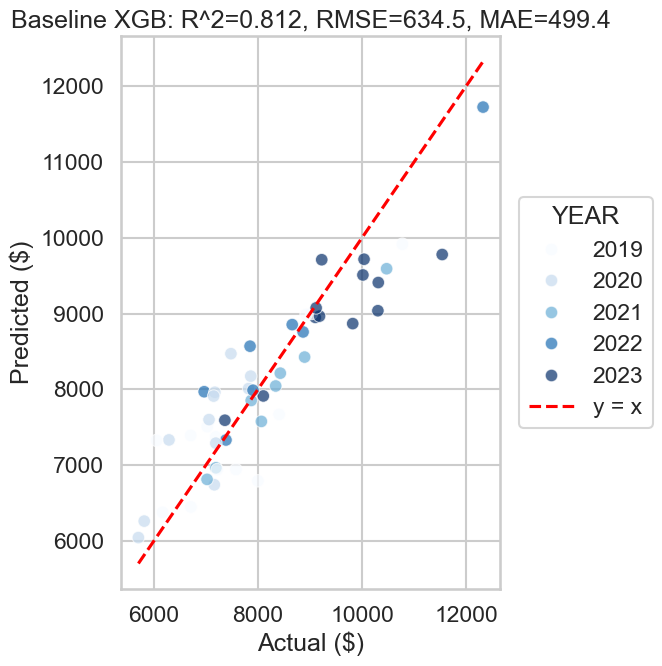

In [18]:
sns.set_theme(style="whitegrid", context="talk")

if 'xgb_baseline_model' in globals() and xgb_available:
    rmse = root_mean_squared_error(y_test_x, y_pred_xgb)
    mae = mean_absolute_error(y_test_x, y_pred_xgb)
    r2 = r2_score(y_test_x, y_pred_xgb)
    plt.figure(figsize=(7,7))
    sns.scatterplot(x=y_test_x, y=y_pred_xgb,
                    hue=X_test_x['YEAR'] if 'YEAR' in X_test_x else None,
                    palette='Blues', alpha=0.7)
    lo, hi = min(y_test_x.min(), y_pred_xgb.min()), max(y_test_x.max(), y_pred_xgb.max())
    plt.plot([lo, hi], [lo, hi], color='red', linestyle='--', label='y = x')
    plt.xlabel('Actual ($)')
    plt.ylabel('Predicted ($)')
    plt.title(f'Baseline XGB: R^2={r2:.3f}, RMSE={rmse:,.1f}, MAE={mae:,.1f}')
    plt.legend(title='YEAR', bbox_to_anchor=(1.02, 0.5), loc='center left')
    plt.tight_layout()
    plt.show()
else:
    print('XGB baseline not available in this environment')


In [19]:
%pip install seaborn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


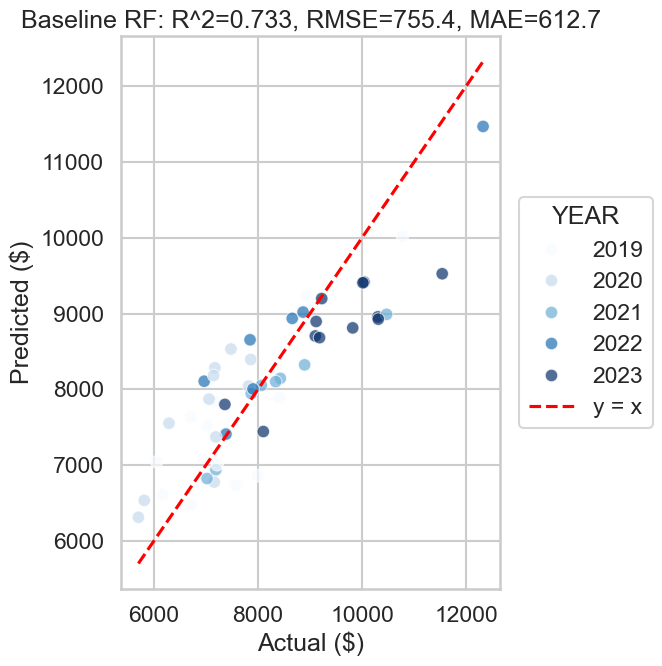

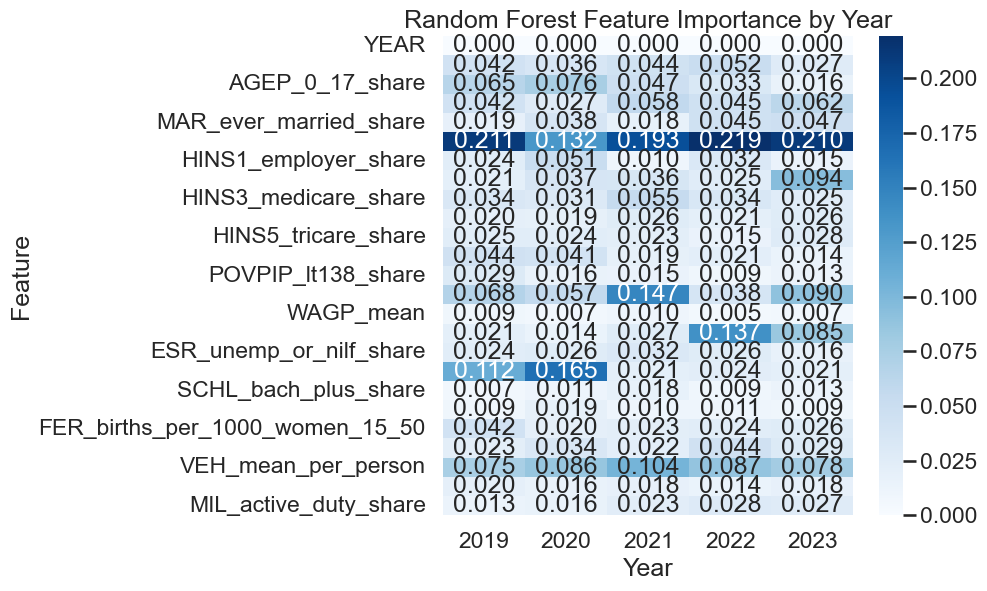

In [21]:

# Baseline RF eval plot + per-year feature-importance heatmap
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

try:
    from sklearn.metrics import root_mean_squared_error
except ImportError:  # fallback for older sklearn versions
    from sklearn.metrics import mean_squared_error
    def root_mean_squared_error(y_true, y_pred):
        return mean_squared_error(y_true, y_pred, squared=False)
from sklearn.metrics import mean_absolute_error, r2_score

sns.set_theme(style="whitegrid", context="talk")

# Scatter + metrics (guarded)
missing = [name for name in ['y_test', 'y_pred', 'X_test'] if name not in globals()]
if missing:
    print(f"Skipping scatter/metrics; missing variables: {', '.join(missing)}")
else:
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    plt.figure(figsize=(7, 7))
    hue_vals = X_test['YEAR'] if 'YEAR' in X_test else None
    sns.scatterplot(
        x=y_test,
        y=y_pred,
        hue=hue_vals,
        palette='Blues',
        alpha=0.7,
    )
    lo, hi = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
    plt.plot([lo, hi], [lo, hi], color='red', linestyle='--', label='y = x')
    plt.xlabel('Actual ($)')
    plt.ylabel('Predicted ($)')
    plt.title(f'Baseline RF: R^2={r2:.3f}, RMSE={rmse:,.1f}, MAE={mae:,.1f}')
    plt.legend(title='YEAR', bbox_to_anchor=(1.02, 0.5), loc='center left')
    plt.tight_layout()
    plt.show()

# Feature importance heatmap by year (per-year RF models)
importance_df = None
if 'df_state_year' in globals() and 'numeric_cols' in globals():
    # target column defined earlier as `target`, fallback to default name
    target_col = 'TOTAL_HEALTH_SPENDING'
    if 'target' in globals():
        target_col = target

    rows = []
    for yr in sorted(df_state_year['YEAR'].unique()):
        df_y = df_state_year[df_state_year['YEAR'] == yr]
        if df_y.shape[0] < 10:
            continue
        X_y = df_y[numeric_cols]
        if target_col not in df_y:
            print(f"Target column '{target_col}' missing for year {yr}; skipping.")
            continue
        y_y = df_y[target_col]
        rf_y = RandomForestRegressor(
            n_estimators=300,
            max_depth=10,
            n_jobs=-1,
            random_state=42,
        )
        rf_y.fit(X_y, y_y)
        rows.append(pd.Series(rf_y.feature_importances_, index=numeric_cols, name=yr))

    if rows:
        importance_df = pd.DataFrame(rows).T  # rows=features, cols=years
        plt.figure(figsize=(10, max(6, len(numeric_cols) * 0.25)))
        sns.heatmap(importance_df, annot=True, fmt=".3f", cmap="Blues")
        plt.xlabel("Year")
        plt.ylabel("Feature")
        plt.title("Random Forest Feature Importance by Year")
        plt.tight_layout()
        plt.show()
    else:
        print("No per-year RF importances computed (too few rows or missing target).")
else:
    print("Run the RF prep cell so df_state_year and numeric_cols exist, or set feature_year_df manually.")


In [23]:
%pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 103.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [plotly]2m1/2 [plotly]

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [37]:
top_n = 5

target_col = 'TOTAL_HEALTH_SPENDING'
if 'target' in globals():
    target_col = target

top_feat_by_year = {}
if 'df_state_year' not in globals() or 'numeric_cols' not in globals():
    print('Run the prep cell first to define df_state_year and numeric_cols.')
elif target_col not in df_state_year.columns:
    print(f"Target column '{target_col}' not found in df_state_year.")
else:
    for yr in sorted(df_state_year['YEAR'].unique()):
        df_y = df_state_year[df_state_year['YEAR'] == yr]
        if df_y.shape[0] < 10:
            continue
        X_y = df_y[numeric_cols]
        y_y = df_y[target_col]
        rf_y = RandomForestRegressor(
            n_estimators=300,
            max_depth=10,
            n_jobs=-1,
            random_state=42,
        )
        rf_y.fit(X_y, y_y)
        s = pd.Series(rf_y.feature_importances_, index=numeric_cols).nlargest(top_n)
        top_feat_by_year[yr] = ', '.join([f"{feat} ({imp:.3f})" for feat, imp in s.items()])
    if top_feat_by_year:
        print(f'Computed top {top_n} features for {len(top_feat_by_year)} years.')
    else:
        print('No per-year importances computed (too few rows or data issues).')


Computed top 5 features for 5 years.


In [38]:
import plotly.express as px


metric_col = 'TOTAL_HEALTH_SPENDING' 
color_range = None  
STATE_TO_ABBR = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'District of Columbia': 'DC',
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL',
    'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS', 'Kentucky': 'KY', 'Louisiana': 'LA',
    'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN',
    'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK', 'Oregon': 'OR',
    'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC', 'South Dakota': 'SD',
    'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 'Virginia': 'VA',
    'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY',
}

if 'df_state_year' not in globals() or 'numeric_cols' not in globals():
    print('df_state_year or numeric_cols missing; run the prep cell first.')
elif 'YEAR' not in df_state_year.columns:
    print("Column 'YEAR' missing in df_state_year; cannot animate.")
elif metric_col not in df_state_year.columns:
    print(f"Column {metric_col} not in df_state_year; choose another metric_col.")
else:
    df_plot = df_state_year.copy()
    if 'ST' not in df_plot.columns and 'STATE_NAME' in df_plot.columns:
        df_plot['ST'] = df_plot['STATE_NAME'].map(STATE_TO_ABBR)
    if 'ST' not in df_plot.columns:
        print("Need 'ST' or 'STATE_NAME' to map to state codes before plotting.")
    else:
        df_plot = df_plot.dropna(subset=['ST', metric_col, 'YEAR'])
        if df_plot.empty:
            print('No data after cleaning for ST/metric/YEAR.')
        else:
            top_n_label = globals().get('top_n', 5)
            if 'top_feat_by_year' in globals():
                df_plot['top_features'] = df_plot['YEAR'].map(top_feat_by_year).fillna('n/a')
            else:
                df_plot['top_features'] = 'n/a (run precompute cell)'

            if color_range is None:
                color_range = (df_plot[metric_col].min(), df_plot[metric_col].max())
            fig = px.choropleth(
                df_plot,
                locations='ST',
                locationmode='USA-states',
                color=metric_col,
                hover_name='STATE_NAME' if 'STATE_NAME' in df_plot.columns else 'ST',
                hover_data={'top_features': True},
                scope='usa',
                color_continuous_scale='Blues',
                animation_frame='YEAR',
                labels={metric_col: metric_col.replace('_', ' '), 'top_features': f'Top {top_n_label} features'},
                range_color=color_range,
                height=550,
            )
            fig.update_layout(title=f"{metric_col.replace('_', ' ')} by state (animated) — hover for top {top_n_label} features")
            fig.update_layout(transition={'duration': 0})
            # Slider/buttons for quick year navigation
            years_sorted = sorted(df_plot['YEAR'].unique())
            fig.update_layout(
                updatemenus=[{
                    'type': 'buttons',
                    'showactive': True,
                    'x': 1.05,
                    'y': 1.15,
                    'buttons': [
                        {
                            'label': 'Play',
                            'method': 'animate',
                            'args': [None, {
                                'frame': {'duration': 800, 'redraw': True},
                                'transition': {'duration': 0},
                                'fromcurrent': True,
                            }]
                        },
                        {
                            'label': 'Pause',
                            'method': 'animate',
                            'args': [[None], {
                                'frame': {'duration': 0, 'redraw': False},
                                'mode': 'immediate',
                            }]
                        }
                    ]
                }],
                sliders=[{
                    'pad': {'t': 50},
                    'x': 0.1,
                    'len': 0.8,
                    'currentvalue': {'prefix': 'Year: '},
                    'steps': [
                        {
                            'label': str(yr),
                            'method': 'animate',
                            'args': [[str(yr)], {'mode': 'immediate', 'frame': {'duration': 0, 'redraw': True}, 'transition': {'duration': 0}}]
                        }
                        for yr in years_sorted
                    ],
                }]
            )

            out_path = 'choropleth_anim.html'
            fig.write_html(out_path, include_plotlyjs='cdn', full_html=True)
            print(f'Wrote animated choropleth to {out_path}')
            try:
                from IPython.display import HTML, display
                display(HTML(fig.to_html(include_plotlyjs='cdn', full_html=False)))
            except Exception as e:
                print('Inline render failed:', e)
                print(f'Open {out_path} in a browser to view the animation.')


Wrote animated choropleth to choropleth_anim.html
